# Simplicial Complexes Development / Validation Notebook
We need a class that can represent a manifold (as a simplicial complex), and then further allows the calculations of geodesics. Currently existing is this package: https://simplicial.readthedocs.io/en/latest/tutorial/build-complex.html
but that doesn't calculate geodesics and does other stuff we don't really need, so that's not super useful.

In [1]:
%load_ext autoreload

import sys
sys.path.append('..')

In [2]:
%autoreload

import matplotlib, time
%matplotlib inline

from tqdm.notebook import tqdm
from topic_manifolds.simplicial_manfiolds import *

# Basic Euclidean Geometry

In [3]:
x1 = Vector([1, 0, 0])
x2 = Vector([0, 1, 0])
x3 = Vector([0, 0, 1])

np.testing.assert_almost_equal(Vector.dist(x1, x2), np.sqrt(2))
assert Vector.angle_between(x1, x2) == np.pi / 2
assert x1.project_onto(x2) == (x1 * 0)

H = Hypersurface(x1, x2, x3)

for x in (x1, x2, x3):
    assert x | H == x, f"Want {x}, got {x | H}"
    
S = Vector((0.1, 0.1, 0.8))
L = Hypersurface(x1, x2)
S_refl = L.reflect_vector_over_self(S)
assert sum(S_refl) == 1

In [4]:
H2 = H.reflect_over_face(L)
H3 = H2.reflect_over_face(H2.drop(x2))
x3_refl = L.reflect_vector_over_self(x3)
H4 = H3.reflect_over_face(H3.drop(x3_refl))
x2_refl = x2 & Hypersurface(x1, x3_refl)
H5 = H4.reflect_over_face(H4.drop(x2_refl))

In [5]:
np.testing.assert_almost_equal((S - (S | H)).norm(), 0)
np.testing.assert_almost_equal((S - (S | H2)).norm(), 0)
np.testing.assert_almost_equal((S - (S | H3)).norm(), 0)
np.testing.assert_almost_equal((S - (S | H4)).norm(), 0)
np.testing.assert_almost_equal((S - (S | H5)).norm(), 0)

S_local = H.proj_vector_onto_self_coord(S)
S_on_H2 = H2.local_to_global(S_local)
assert S_on_H2 == S_refl

In [6]:
print("Testing reflections... Should print nothing.")

S_refl_2 = S_refl & H2.drop(x2)
S_on_H3 = H3.local_to_global(S_local)
if S_on_H3 != S_refl_2:
    print(S_on_H3, "vs.", S_refl_2)
    
S_refl_3 = S_refl_2 & H3.drop(x3_refl)
S_on_H4 = H4.local_to_global(S_local)
if S_on_H4 != S_refl_3:
    print(S_on_H4, "vs.", S_refl_3)

S_refl_4 = S_refl_3 & H4.drop(x2_refl)
S_on_H5 = H5.local_to_global(S_local)
if S_on_H5 != S_refl_4:
    print(S_on_H5, "vs.", S_refl_4)
    
S_all_the_way_back = S_refl_4 & Hypersurface(x1, x3)
if S_all_the_way_back != S:
    print(S, "vs.", S_all_the_way_back)

Testing reflections... Should print nothing.


Given coincident points, you should only see 4 triangles.


/crimea/conda_envs/topic_manifolds/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/crimea/conda_envs/topic_manifolds/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


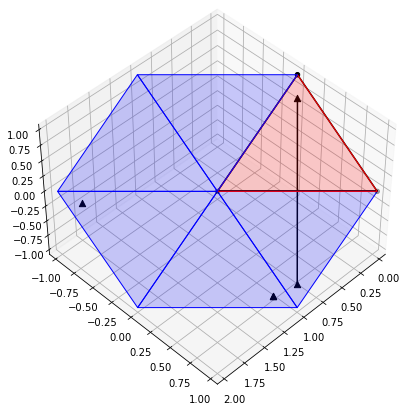

In [7]:
print("Given coincident points, you should only see 4 triangles.")
fig, ax = H.plot(
    extra_points=[S, S_refl, S_refl_2, S_on_H3, S_on_H4],
    extra_lines=[L, (S, S_refl)],
    extra_faces=[H2, H3, H4, H5, H.reflect_over_face(H.drop(x2))],
    # view_kwargs TODO(mmd): should be figured out programmatically
    elev=45, azim=45,
)

# Specialized functionality for (Planar) Simplicial Tilings.

In [8]:
S1 = SimplicialTiling(3)
S2 = S1.new_reflected((0, 1, 3))
S3 = S2.new_reflected((4, 3, 1))
S4 = S1.new_reflected((1, 2, 5))
S5 = S1.new_reflected((0, 2, 6))

S1_point = S1.simplicial_to_global({0: 0.1, 1: 0.1, 2: 0.8})
S2_point = S2.simplicial_to_global({0: 0.6, 1: 0.04, 3: 0.36})
S3_point = S3.simplicial_to_global({4: 0.25, 1: 0.1, 3: 0.65})
S5_point = S5.simplicial_to_global({0: 0.333, 2: 0.333, 6: 0.334})

S4_edge_point = S4.simplicial_to_global({5:1, 1: 0, 2: 0})
S3_edge_point = S3.simplicial_to_global({4:0.75, 1: 0.2, 3: 0.05})

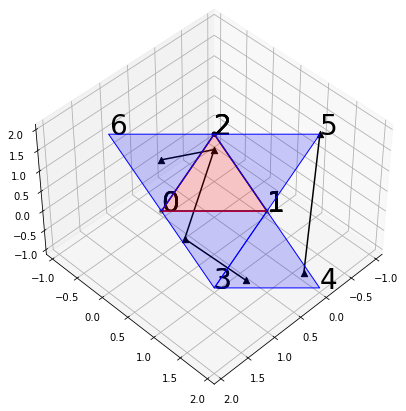

In [9]:
fig, ax = S1.plot(
    extra_points=[
        S1_point, S2_point, S3_point, S5_point,
        S4_edge_point, S3_edge_point,
    ],
    extra_lines=[
        Hypersurface(S1_point, S2_point),
        Hypersurface(S1_point, S5_point),
        Hypersurface(S2_point, S3_point),
        Hypersurface(S3_edge_point, S4_edge_point),
    ],
    extra_faces=[S2, S3, S4, S5],
)

## Bulk Simplicial Coordinate Transformation

In [10]:
S4_edge_point

Vector(array([-1.,  1.,  1.]))

In [11]:
xs = S4.simplicial_to_global_bulk([
    {5:1, 1: 0, 2: 0},
    {5:0.9, 1: 0.05, 2: 0.05},
    {5:0.8, 1: 0.1, 2: 0.1},
    {5:0.7, 1: 0.15, 2: 0.15},
    {5:0.6, 1: 0.2, 2: 0.2}
])
print(xs)

[[-1.    1.    1.  ]
 [-0.9   0.95  0.95]
 [-0.8   0.9   0.9 ]
 [-0.7   0.85  0.85]
 [-0.6   0.8   0.8 ]]


## Testing Intersection Checking

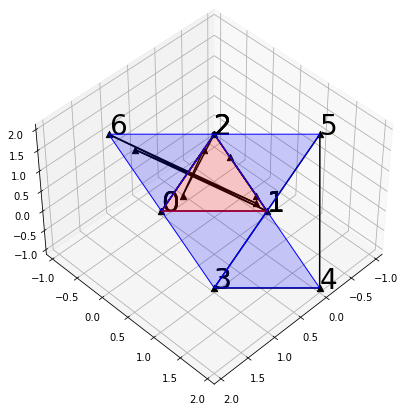

In [12]:
S012 = SimplicialTiling(3)
S013 = S012.new_reflected((0, 1, 3))
S134 = S013.new_reflected((4, 3, 1))
S125 = S012.new_reflected((1, 2, 5))
S026 = S012.new_reflected((0, 2, 6))

# Points
v0     = S012.simplicial_to_global({0: 1,    1: 0,    2: 0})
v0_alt = S012.simplicial_to_global({0: 0.7,  1: 0.1,  2: 0.2})
v1     = S012.simplicial_to_global({0: 0,    1: 1,    2: 0})
v1_alt = S012.simplicial_to_global({0: 0.05, 1: 0.85, 2: 0.1})
v2     = S012.simplicial_to_global({0: 0,    1: 0,    2: 1})
v2_alt = S012.simplicial_to_global({0: 0.2,  1: 0,    2: 0.8})
v6     = S026.simplicial_to_global({0: 0,    2: 0,    6: 1})
v6_alt = S026.simplicial_to_global({0: 0.2,  2: 0.15, 6: 0.65})

# Parallel, non-collinear
v3 = S013.simplicial_to_global({0: 0, 1: 0, 3: 1})
L_02 = Hypersurface(v0, v2)
L_13 = Hypersurface(v1, v3)

# Parallel, collinear
v_12_1   = S125.simplicial_to_global({1: 0.8, 2: 0.2, 5: 0})
v_12_2   = S125.simplicial_to_global({1: 0.3, 2: 0.7, 5: 0})
L_12     = Hypersurface(v1, v2)
L_12_col = Hypersurface(v_12_1, v_12_2)

# Endpoints intersect
v4 = S134.simplicial_to_global({1: 0, 3: 0, 4: 1})
v5 = S125.simplicial_to_global({1: 0, 2: 0, 5: 1})
L_45 = Hypersurface(v4, v5) # This will have endpoints_coincident_endpoints with L_35
L_35 = Hypersurface(v3, v5) # This will have endpoints_coincident_interior with L_12
L_34 = Hypersurface(v3, v4) # This will have endpoints_coincident (and nothing else) with L_12

# For Interior Intersections:
L_02s = [Hypersurface(*eps) for eps in itertools.product((v0, v0_alt), (v2, v2_alt))]
L_16s = [Hypersurface(*eps) for eps in itertools.product((v1, v1_alt), (v6, v6_alt))]

fig, ax = S1.plot(
    extra_points = [v0, v0_alt, v1, v1_alt, v2, v2_alt, v6, v6_alt, v_12_1, v_12_2, v3, v4, v5],
    extra_lines  = L_02s + L_16s + [L_12, L_12_col, L_45, L_35, L_34],
    extra_faces  = [S2, S3, S4, S5],
)

#### `is_parallel`

In [13]:
out_L02_L13 = L_02.segments_intersect(L_13)
out_L13_L02 = L_13.segments_intersect(L_02)

for o1, o2 in zip(out_L02_L13, out_L13_L02): assert o1 == o2, f"{out_L02_L13}\nvs.\n{out_L13_L02}"

(
    is_parallel, is_collinear,
    (endpoints_coincident, endpoints_coincident_interior, endpoints_coincident_endpoints),
    interiors_intersect
) = out_L02_L13

assert is_parallel and not is_collinear
assert not (endpoints_coincident or endpoints_coincident_endpoints or endpoints_coincident_interior)
assert not interiors_intersect

#### `is_collinear`

In [14]:
out_L12_L12col = L_12.segments_intersect(L_12_col)
out_L12col_L12 = L_12_col.segments_intersect(L_12)

for o1, o2 in zip(out_L12_L12col, out_L12col_L12): assert o1 == o2, f"{out_L12_L12col}\nvs.\n{out_L12col_L12}"

(
    is_parallel, is_collinear,
    (endpoints_coincident, endpoints_coincident_interior, endpoints_coincident_endpoints),
    interiors_intersect
) = out_L12_L12col

assert is_parallel and is_collinear
assert endpoints_coincident and (not endpoints_coincident_endpoints) and endpoints_coincident_interior
assert interiors_intersect

#### `endpoints_coinicident`
Also `endpoints_coincident_interior`, `endpoints_coincident_endpoints`

In [15]:
for (L1, L2), (coincident, coincident_interior, coincident_endpoints) in [
    ((L_45, L_35),     (True, False, True)),
    ((L_35, L_12),     (True, True, False)),
    ((L_12, L_34),     (True, False, False)),
    ((L_12_col, L_35), (False, False, False)),
]:
    out_L1_L2 = L1.segments_intersect(L2)
    out_L2_L1 = L2.segments_intersect(L1)
    
    for o1, o2 in zip(out_L1_L2, out_L2_L1): assert o1 == o2, f"{out_L1_L2}\nvs.\n{out_L2_L1}"
    
    (
        is_parallel, is_collinear,
        (endpoints_coincident, endpoints_coincident_interior, endpoints_coincident_endpoints),
        interiors_intersect
    ) = out_L1_L2
    
    assert not (is_parallel or is_collinear)
    
    assert endpoints_coincident == coincident
    assert endpoints_coincident_interior == coincident_interior
    assert endpoints_coincident_endpoints == coincident_endpoints
    
    assert not interiors_intersect

#### `interiors_intersect`

In [16]:
for L1, L2 in itertools.product(L_02s, L_16s):
    out_L1_L2 = L1.segments_intersect(L2)
    out_L2_L1 = L2.segments_intersect(L1)
    
    for o1, o2 in zip(out_L1_L2, out_L2_L1): assert o1 == o2, f"{out_L1_L2}\nvs.\n{out_L2_L1}"
    
    (
        is_parallel, is_collinear,
        (endpoints_coincident, endpoints_coincident_interior, endpoints_coincident_endpoints),
        interiors_intersect
    ) = out_L1_L2
    
    assert not (is_parallel or is_collinear)
    assert not (endpoints_coincident or endpoints_coincident_endpoints or endpoints_coincident_interior)
    assert interiors_intersect

# Manifolds

## Constructing & Basic Visualization

Manifold has 8 simplices


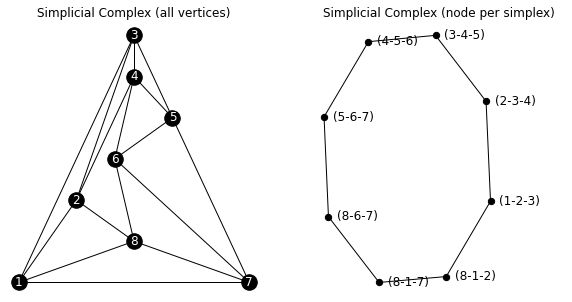

In [17]:
taurus_simplices = [
    (1, 2, 3), (2, 3, 4), (3, 4, 5), (4, 5, 6), (5, 6, 7), (6, 7, 8), (7, 8, 1), (8, 1, 2)
]
taurus_M = LabeledSimplicialManifold(taurus_simplices)
fig = taurus_M.display()

No planar embedding exists: G is not planar.
Trying neato
Manifold has 7 simplices


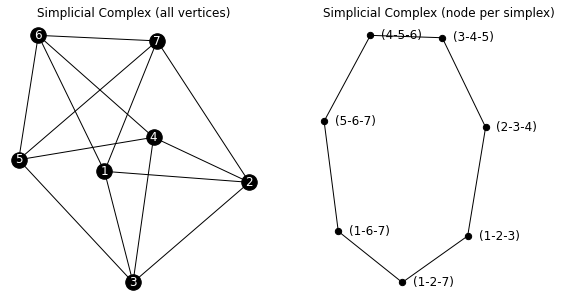

In [18]:
mobius_kwargs = {'simplices': [
    (1, 2, 3), (2, 3, 4), (3, 4, 5), (4, 5, 6), (5, 6, 7), (6, 7, 1), (7, 1, 2)
]}
mobius_M = LabeledSimplicialManifold(**mobius_kwargs)
fig = mobius_M.display()

## (Approximate) Geodesics
### On a Single Simplex

Points have distance 0.14


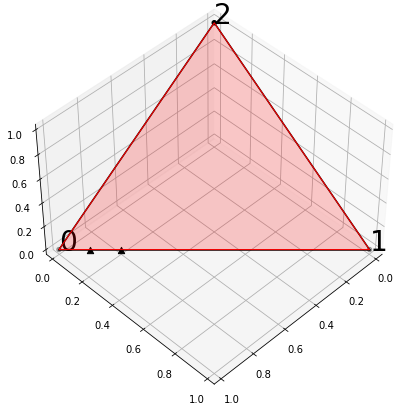

In [19]:
on_mobius = mobius_M.approximate_geodesic_distance(
    {1: 0.9, 2: 0.1, 3: 0}, {1: 0.8, 2: 0.2, 3: 0}
)

S = SimplicialTiling(N=3)
on_simp = Vector.dist(
    S.simplicial_to_global({0: 0.9, 1: 0.1, 2: 0}), S.simplicial_to_global({0: 0.8, 1: 0.2, 2: 0})
)
np.testing.assert_almost_equal(on_mobius, on_simp)

print(f"Points have distance {on_simp:.2f}")
fig, ax = S.plot(
    extra_points = [
        S.simplicial_to_global({0: 0.9, 1: 0.1, 2: 0}),
        S.simplicial_to_global({0: 0.8, 1: 0.2, 2: 0}),
    ]
)

### Spanning 3 Simplices

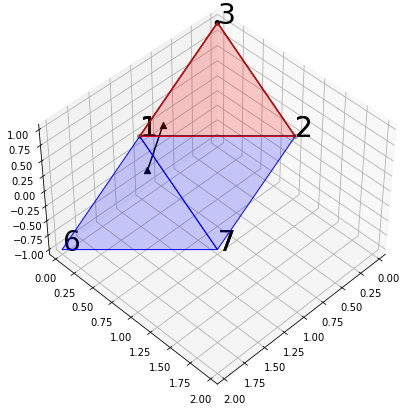

In [20]:
p1, p2 = {1: 0.8, 2: 0.1, 3: 0.1}, {1: 0.7, 7: 0.2, 6: 0.1}

on_mobius = mobius_M.approximate_geodesic_distance(p1, p2)

S1 = SimplicialTiling(N=3, vertex_ids=(1, 2, 3))
S2 = S1.new_reflected((1, 2, 7))
S3 = S2.new_reflected((1, 6, 7))

x1 = S1.simplicial_to_global(p1)
x2 = S3.simplicial_to_global(p2)

on_simplicial_tiling = Vector.dist(x1, x2)

np.testing.assert_almost_equal(on_mobius, on_simplicial_tiling)

L = Hypersurface(x1, x2)
fig, ax = S1.plot(
    extra_points = [x1, x2],
    extra_lines = [L],
    extra_faces = [S2, S3],
)

### Risking Boundary Intersections

For this one we have to use a different manifold so we can be sure the lines will go where we want. We'll make it first as a simplicial construct. We'll test this both when the points are on the interior of the simplex and when they're on the boundary.

Invalid distance off-manifold is 0.86/2.45
Invalid distance on-manifold is 0.88/2.83
Valid distance on-manifold is 0.86/2.45
Valid distance off-manifold is 0.88/2.83



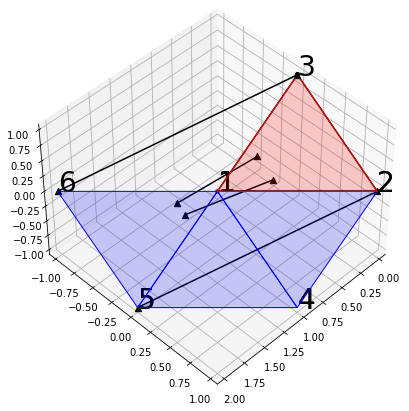

In [21]:
S1 = SimplicialTiling(N=3, vertex_ids=(1, 2, 3))
S2 = S1.new_reflected((1, 2, 4))
S3 = S2.new_reflected((1, 4, 5))
S4 = S3.new_reflected((1, 5, 6))

# With a boundary intersection
invalid_p1_int, invalid_p2_int = {1: 0.6, 2: 0.1, 3: 0.3}, {1: 0.7, 5: 0.1, 6: 0.2}
invalid_p1_bnd, invalid_p2_bnd = {1: 0,   2: 0,   3: 1},   {1: 0,   5: 0,   6: 1}

# And with no boundary intersection
valid_p1_int, valid_p2_int = {1: 0.6, 2: 0.3, 3: 0.1}, {1: 0.7, 5: 0.2, 6: 0.1}
valid_p1_bnd, valid_p2_bnd = {1: 0,   2: 1,   3: 0},   {1: 0,   5: 1,   6: 0}

invalid_x1_int = S1.simplicial_to_global(invalid_p1_int)
invalid_x2_int = S4.simplicial_to_global(invalid_p2_int)
invalid_x1_bnd = S1.simplicial_to_global(invalid_p1_bnd)
invalid_x2_bnd = S4.simplicial_to_global(invalid_p2_bnd)

valid_x1_int = S1.simplicial_to_global(valid_p1_int)
valid_x2_int = S4.simplicial_to_global(valid_p2_int)
valid_x1_bnd = S1.simplicial_to_global(valid_p1_bnd)
valid_x2_bnd = S4.simplicial_to_global(valid_p2_bnd)

e1 = S1.simplicial_to_global({1: 1, 2: 0, 3: 0})

simplex_euc_dist_invalid_int = Vector.dist(invalid_x1_int, invalid_x2_int)
simplex_euc_dist_invalid_bnd = Vector.dist(invalid_x1_bnd, invalid_x2_bnd)
through_e1_dist_invalid_int  = Vector.dist(invalid_x1_int, e1) + Vector.dist(e1, invalid_x2_int)
through_e1_dist_invalid_bnd  = Vector.dist(invalid_x1_bnd, e1) + Vector.dist(e1, invalid_x2_bnd)

simplex_euc_dist_valid_int   = Vector.dist(valid_x1_int, valid_x2_int)
simplex_euc_dist_valid_bnd   = Vector.dist(valid_x1_bnd, valid_x2_bnd)
through_e1_dist_valid_int    = Vector.dist(valid_x1_int, e1) + Vector.dist(e1, valid_x2_int)
through_e1_dist_valid_bnd    = Vector.dist(valid_x1_bnd, e1) + Vector.dist(e1, valid_x2_bnd)

invalid_L_int = Hypersurface(invalid_x1_int, invalid_x2_int)
invalid_L_bnd = Hypersurface(invalid_x1_bnd, invalid_x2_bnd)
valid_L_int   = Hypersurface(valid_x1_int, valid_x2_int)
valid_L_bnd   = Hypersurface(valid_x1_bnd, valid_x2_bnd)

S1.plot(
    extra_points = [
        invalid_x1_int, invalid_x2_int, invalid_x1_bnd, invalid_x2_bnd,
        valid_x1_int, valid_x2_int, valid_x1_bnd, valid_x2_bnd
    ],
    extra_lines = [invalid_L_int, invalid_L_bnd, valid_L_int, valid_L_bnd],
    extra_faces = [S2, S3, S4],
)

print(
    f"Invalid distance off-manifold is {simplex_euc_dist_invalid_int:.2f}/{simplex_euc_dist_invalid_bnd:.2f}\n"
    f"Invalid distance on-manifold is {through_e1_dist_invalid_int:.2f}/{through_e1_dist_invalid_bnd:.2f}\n"
    f"Valid distance on-manifold is {simplex_euc_dist_valid_int:.2f}/{simplex_euc_dist_valid_bnd:.2f}\n"
    f"Valid distance off-manifold is {through_e1_dist_valid_int:.2f}/{through_e1_dist_valid_bnd:.2f}\n"
)

In [22]:
simple_M = LabeledSimplicialManifold(simplices=((1,2,3), (1, 2, 4), (1,4,5), (1,5,6)))

manifold_dist_invalid_int = simple_M.approximate_geodesic_distance(invalid_p1_int, invalid_p2_int)
manifold_dist_invalid_bnd = simple_M.approximate_geodesic_distance(invalid_p1_bnd, invalid_p2_bnd)
manifold_dist_valid_int   = simple_M.approximate_geodesic_distance(valid_p1_int, valid_p2_int)
manifold_dist_valid_bnd   = simple_M.approximate_geodesic_distance(valid_p1_bnd, valid_p2_bnd)

for got, want, wrong_want_opt in [
    (manifold_dist_invalid_int, through_e1_dist_invalid_int, simplex_euc_dist_invalid_int),
    (manifold_dist_invalid_bnd, through_e1_dist_invalid_bnd, simplex_euc_dist_invalid_bnd),
    (manifold_dist_valid_int, simplex_euc_dist_valid_int, through_e1_dist_valid_int),
    (manifold_dist_valid_bnd, simplex_euc_dist_valid_bnd, through_e1_dist_valid_bnd),
]:
    print(f"{got:.2f} should be {want:.2f}, *not* {wrong_want_opt:.2f}")
    np.testing.assert_almost_equal(got, want)

0.88 should be 0.88, *not* 0.86
2.83 should be 2.83, *not* 2.45
0.86 should be 0.86, *not* 0.88
2.45 should be 2.45, *not* 2.83


### Efficient Pairwise Distance Calculations
#### Validation

In [23]:
xs = [
    invalid_p1_int, invalid_p2_int, invalid_p1_bnd, invalid_p2_bnd,
    valid_p1_int, valid_p2_int, valid_p1_bnd, valid_p2_bnd
] + simple_M.sample_points(10)

N = len(xs)

In [24]:
efficient_pairwise_distances_start = time.time()
dists_efficient = simple_M.efficient_pairwise_distances(xs)
efficient_pairwise_distances_end = time.time()

In [25]:
approximate_geodesic_distance_start = time.time()
dists_appr = np.ones((N, N)) * float('inf')
for i in range(N):
    for j in range(i+1, N):
        try:
            dist = simple_M.approximate_geodesic_distance(xs[i], xs[j])
            dists_appr[i][j] = dist
            dists_appr[j][i] = dist
        except:
            print(f"xs[i] = {xs[i]},\nxs[j] = {xs[j]}")
            raise
for i in range(N): dists_appr[i][i] = 0
    
approximate_geodesic_distance_end = time.time()

In [26]:
print(
    "`approximate_geodesic_distance` took "
    f"{(approximate_geodesic_distance_end - approximate_geodesic_distance_start) / 60} minutes. "
    f"`efficient_pairwise_distances` took "
    f"{(efficient_pairwise_distances_end - efficient_pairwise_distances_start) / 60} minutes."
)
np.testing.assert_allclose(dists_appr, dists_efficient, atol=1e-4, rtol=1e-4)

`approximate_geodesic_distance` took 1.9491198778152465 minutes. `efficient_pairwise_distances` took 0.3793599843978882 minutes.


#### Scaling

Manifold has 7 simplices


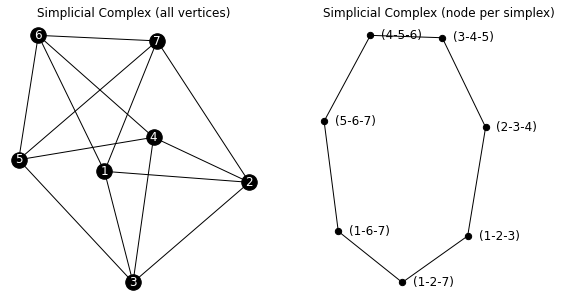

In [27]:
fig = mobius_M.display()

In [28]:
num_points = (5, 10, 20, 40, 80)
eff_times, appr_times = [], []
for N_pts in tqdm(num_points):
    xs = mobius_M.sample_points(N_pts)
    N = len(xs)
    
    efficient_pairwise_distances_start = time.time()
    dists_efficient = mobius_M.efficient_pairwise_distances(xs)
    efficient_pairwise_distances_end = time.time()
    eff_times.append(efficient_pairwise_distances_end - efficient_pairwise_distances_start)
    
    approximate_geodesic_distance_start = time.time()
    dists_appr = np.ones((N, N)) * float('inf')
    for i in range(N):
        for j in range(i+1, N):
            dist = mobius_M.approximate_geodesic_distance(xs[i], xs[j])
            dists_appr[i][j] = dist
            dists_appr[j][i] = dist
    for i in range(N): dists_appr[i][i] = 0

    approximate_geodesic_distance_end = time.time()
    appr_times.append(approximate_geodesic_distance_end-approximate_geodesic_distance_start)
    
    np.testing.assert_allclose(dists_appr, dists_efficient, atol=1e-4, rtol=1e-4)

  0%|          | 0/5 [00:00<?, ?it/s]

Hypersurface([[1. 0. 0.], [0. 0. 1.]]) Hypersurface([[-0.68845404  0.01120144  1.6772526 ], [0.50944594 0.01738275 0.47317131]])
0.024326649010445588 0.018023140635235392 0.013718905271192497 0.021289435022801
Hypersurface([[0. 0. 1.], [-1.  0.  2.]]) Hypersurface([[-0.68845404  0.01120144  1.6772526 ], [0.50944594 0.01738275 0.47317131]])
0.018023140635235392 0.01171963226125938 0.013718905271192454 0.021289435022801
Hypersurface([[0. 0. 1.], [-1.  0.  2.]]) Hypersurface([[-0.28510176  0.01023199  1.27486976], [0.47350246 0.00673217 0.51976537]])
0.010945813066322724 0.01660919446595353 0.012531579694276396 0.008245190728601366
Hypersurface([[0. 0. 1.], [-1.  0.  2.]]) Hypersurface([[-0.50333103  0.00520164  1.49812938], [0.94120143 0.02563678 0.03316179]])
0.014984242567837848 0.002218695855187248 0.006370683042856584 0.031398509926239715
Hypersurface([[0. 0. 1.], [-1.  0.  2.]]) Hypersurface([[-0.70074322  0.0064183   1.69432492], [0.94120143 0.02563678 0.03316179]])
0.0178010414742

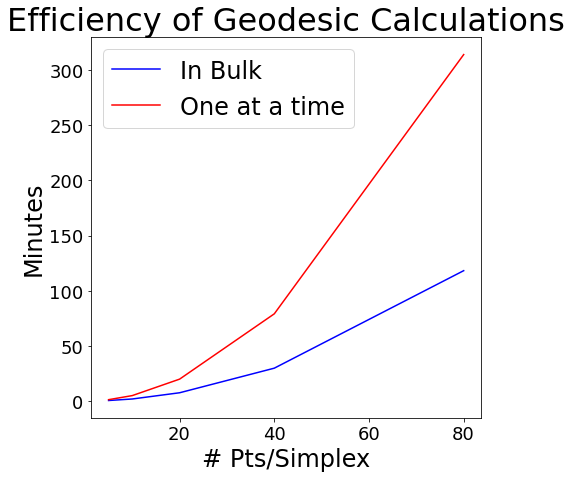

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
ax.plot(num_points, np.array(eff_times) / 60, color='b', label='In Bulk')
ax.plot(num_points, np.array(appr_times) / 60, color='r', label='One at a time')

ax.set_title('Efficiency of Geodesic Calculations', fontsize=32)
ax.set_ylabel('Minutes', fontsize=24)
ax.set_xlabel('# Pts/Simplex', fontsize=24)
ax.tick_params(axis='both', labelsize=18)
ax.legend(fontsize=24)

None

## Simple Topologies
### A Simple Taurus

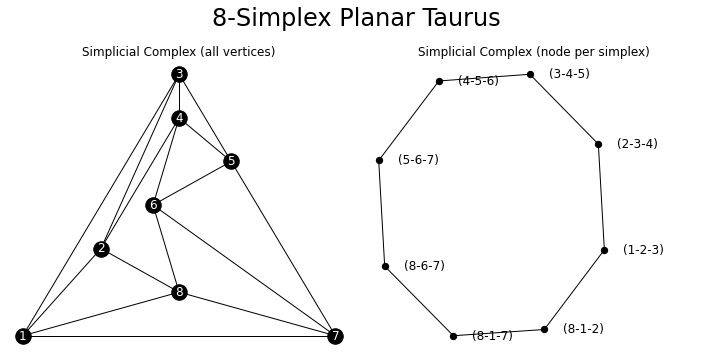

In [30]:
taurus_M = LabeledSimplicialManifold(taurus_simplices)

fig, ax = taurus_M.display(do_print=False)
fig.suptitle(f"{len(taurus_M.simplices)}-Simplex Planar Taurus", fontsize=24)
fig.tight_layout()

In [31]:
%%time

taurus_all_pts, taurus_all_dists, taurus_all_Gs = {}, {}, {}

# Let's look at how the topology varies for the Taurus as a function of $N$ and $r$
N_options = (1, 5, 10, 20)
r_options = (0.1, 0.5, 1.0, 2.0)

for N in tqdm(N_options, desc="Varying N", leave=False):
    if N not in taurus_all_pts: taurus_all_pts[N] = taurus_M.sample_points(N)
    
    for r in tqdm(r_options, desc="Varying radius", leave=False):
        precomputed_dists = taurus_all_dists[N] if N in taurus_all_dists else None
        G, dists = taurus_M.radius_nearest_neighbor_graph(
            r, *taurus_all_pts[N], precomputed_distance_matrix=precomputed_dists
        )
        
        taurus_all_Gs[(N, r)] = G
        taurus_all_dists[N] = dists

Varying N:   0%|          | 0/4 [00:00<?, ?it/s]

Varying radius:   0%|          | 0/4 [00:00<?, ?it/s]

Warning! r (2.0) greater than recommended value (1.224744871391589)


Varying radius:   0%|          | 0/4 [00:00<?, ?it/s]

Warning! r (2.0) greater than recommended value (1.224744871391589)


Varying radius:   0%|          | 0/4 [00:00<?, ?it/s]

Warning! r (2.0) greater than recommended value (1.224744871391589)


Varying radius:   0%|          | 0/4 [00:00<?, ?it/s]

Hypersurface([[1. 0. 0.], [0. 0. 1.]]) Hypersurface([[-1.00348799  0.01789737  1.98559062], [0.64699119 0.00701635 0.34599246]])
0.005761842475732236 0.013862717844354553 0.02191971641652744 0.008593244547365786
Warning! r (2.0) greater than recommended value (1.224744871391589)
CPU times: user 11min 12s, sys: 35.1 s, total: 11min 47s
Wall time: 11min 8s


Varying N:   0%|          | 0/4 [00:00<?, ?it/s]

Varying radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying radius:   0%|          | 0/4 [00:00<?, ?it/s]

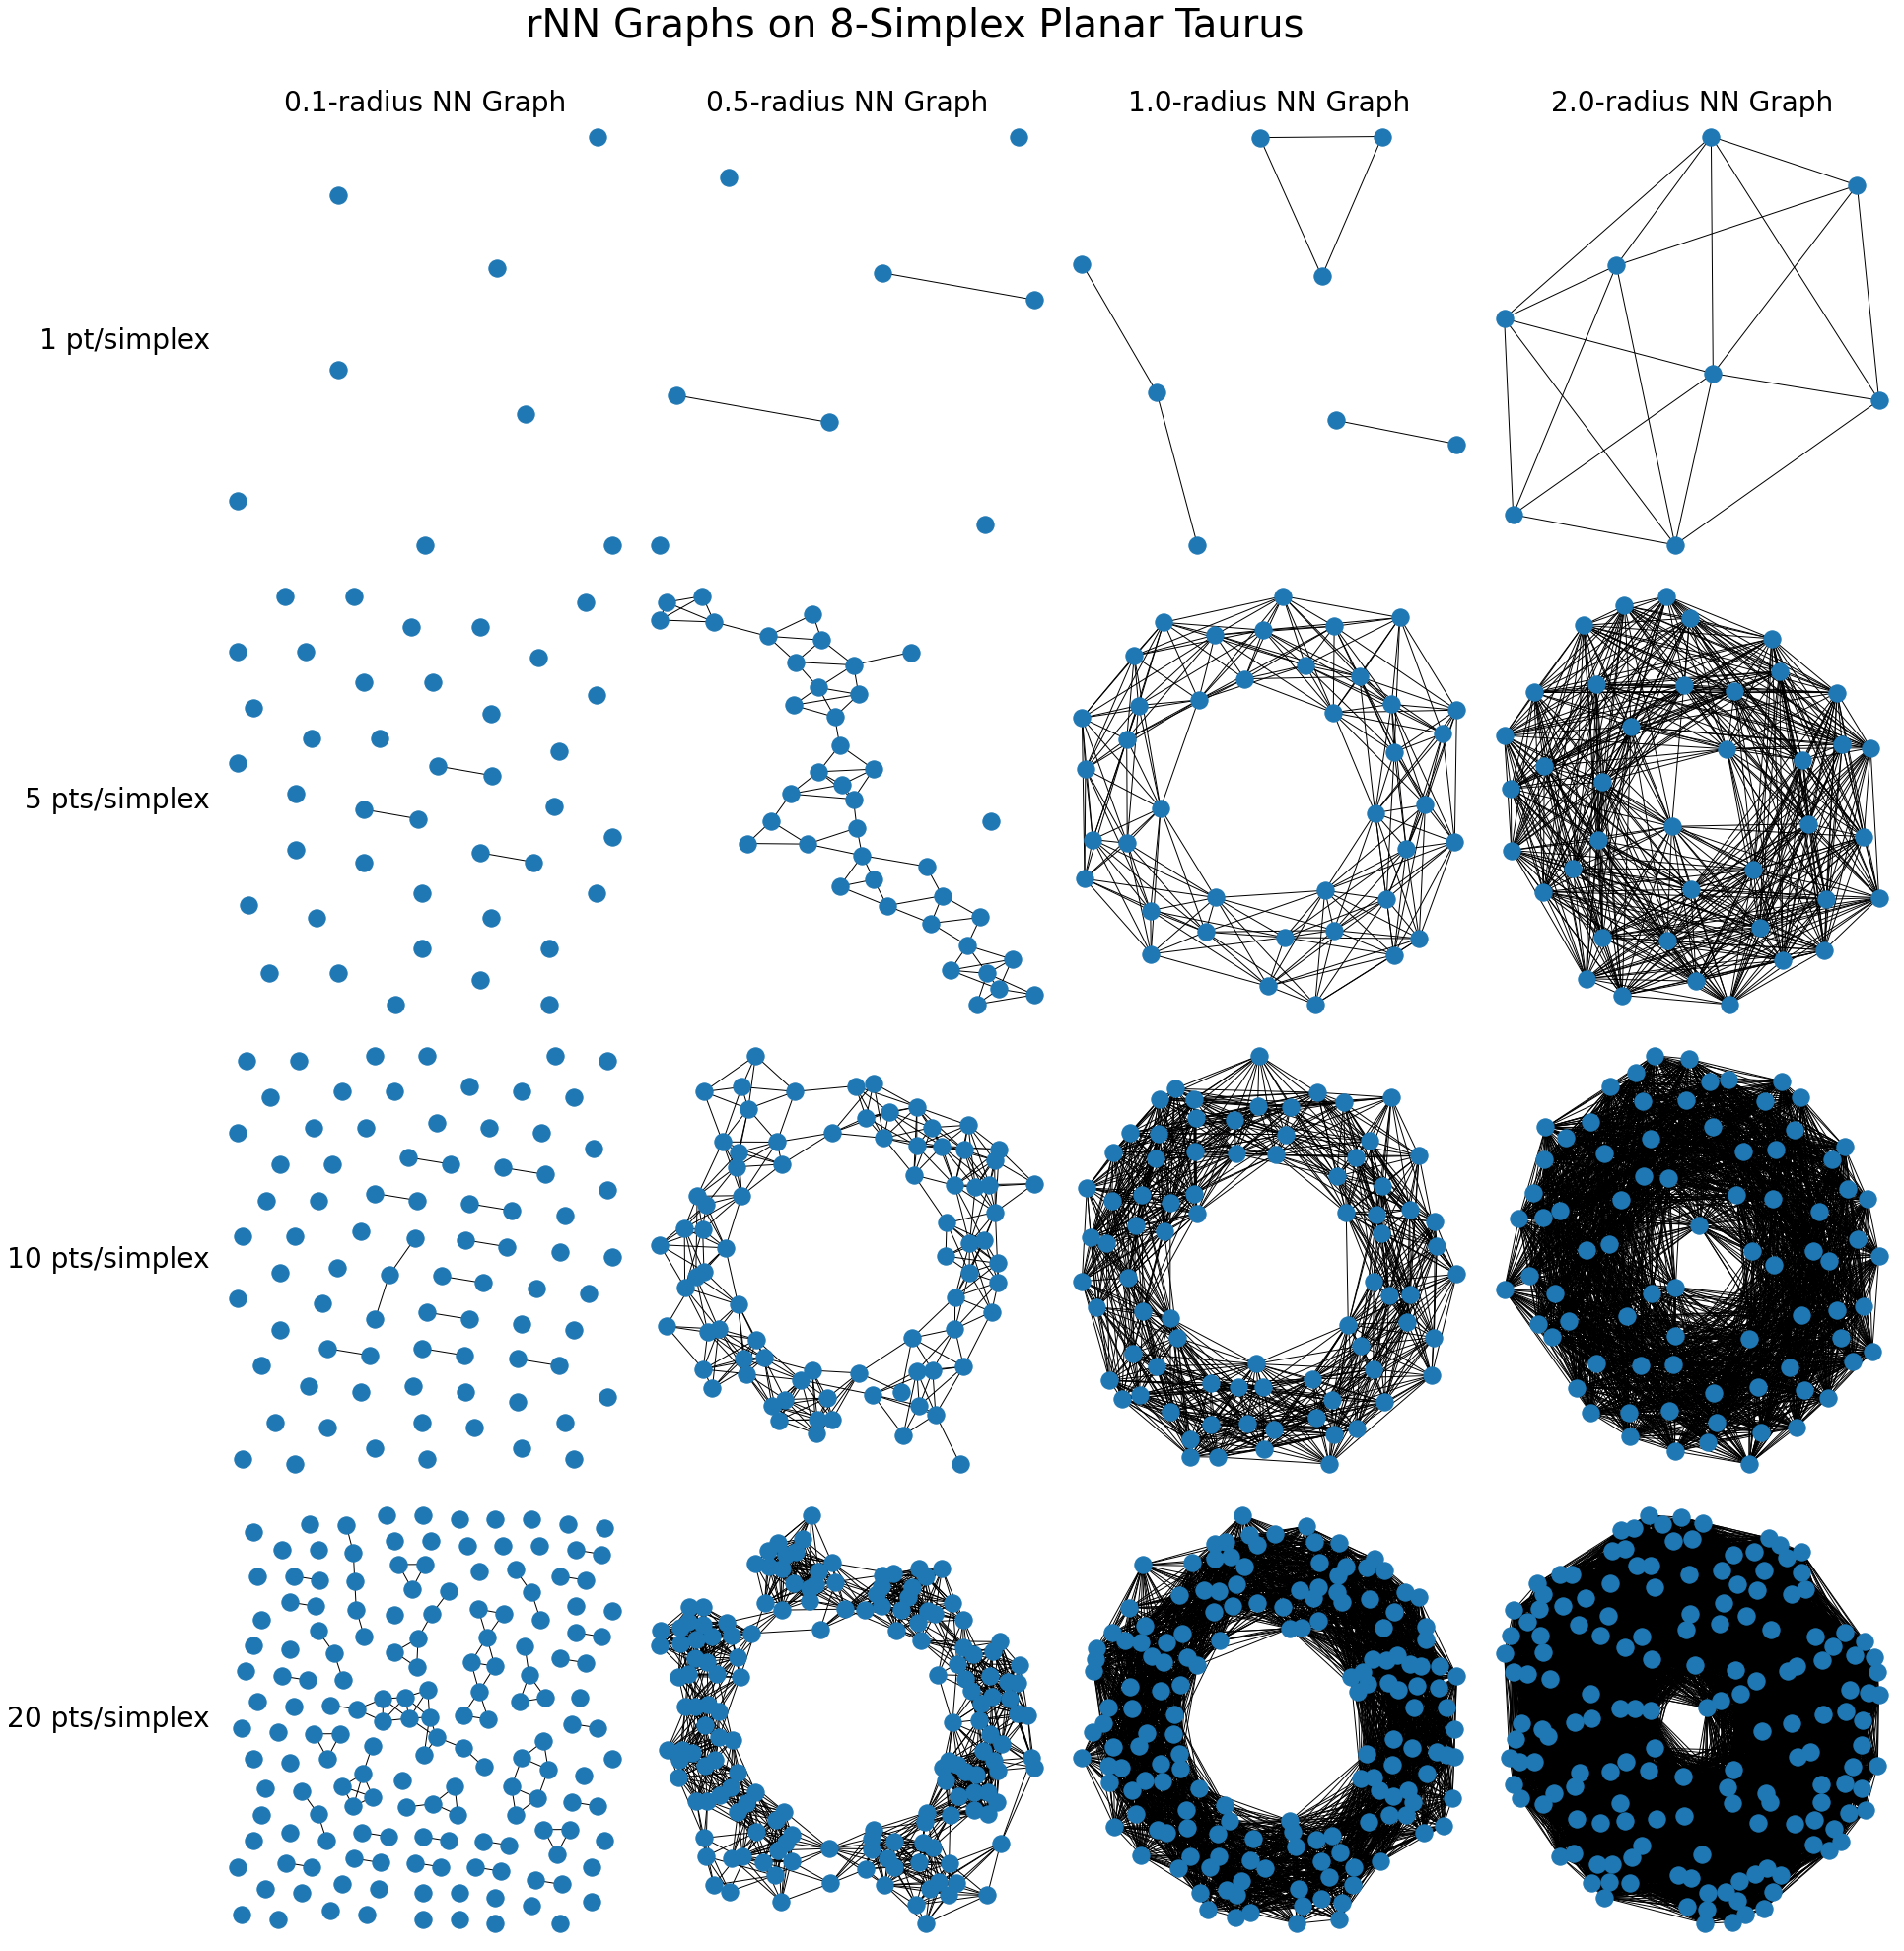

In [32]:
# Plotting
H, W = len(N_options), len(r_options)
taurus_fig, taurus_axes = plt.subplots(nrows=H, ncols=W, figsize=(7*W, 7*H))

pad = 5 # in points
taurus_fig.suptitle(f"rNN Graphs on {len(taurus_M.simplices)}-Simplex Planar Taurus", fontsize=40)

for N, taurus_ax_row in tqdm(list(zip(N_options, taurus_axes)), desc="Varying N", leave=False):   
    for r, taurus_ax in tqdm(list(zip(r_options, taurus_ax_row)), desc="Varying radius", leave=False):
        if N == N_options[0]:
            taurus_ax.annotate(
                f"{r}-radius NN Graph", xy=(0.5, 1), xytext=(0, pad), xycoords='axes fraction',
                textcoords='offset points', size=28, ha='center', va='baseline'
            )
        if r == r_options[0]:
            taurus_ax.annotate(
                f"{N} pt{'s' if N > 1 else ''}/simplex", xy=(0, 0.5),
                xytext=(-taurus_ax.yaxis.labelpad - pad, 0),
                xycoords='axes fraction', textcoords='offset points', size=28, ha='right', va='center'
            )

        G = taurus_all_Gs[(N, r)]
        nx.draw(G, pos=graphviz_layout(G, 'neato'), ax=taurus_ax)
        
taurus_fig.tight_layout()
taurus_fig.subplots_adjust(left=0.15, top=0.925)

### A Mobius Strip

No planar embedding exists: G is not planar.
Trying neato
Manifold has 7 simplices


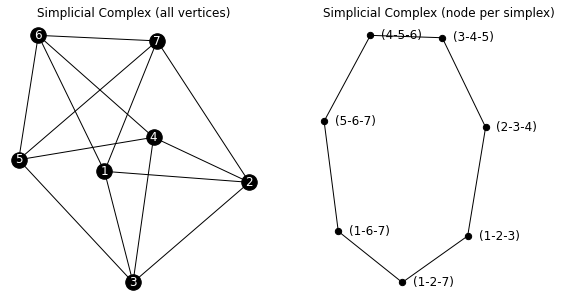

In [33]:
mobius_M = LabeledSimplicialManifold(**mobius_kwargs)
fig = mobius_M.display()

In [34]:
%%time

# Let's look at how the topology varies for the mobius as a function of $N$ and $r$
N_options = (1, 5, 10, 20)
r_options = (0.1, 0.5, 1.0, 2.0)

mobius_all_pts, mobius_all_dists, mobius_all_Gs = {}, {}, {}
for N in tqdm(N_options, desc="Varying N", leave=False):
    mobius_all_pts[N] = mobius_M.sample_points(N)
    
    for r in tqdm(r_options, desc="Varying radius", leave=False):
        precomputed_dists = mobius_all_dists[N] if N in mobius_all_dists else None
        G, dists = mobius_M.radius_nearest_neighbor_graph(
            r, *mobius_all_pts[N], precomputed_distance_matrix=precomputed_dists
        )
        
        mobius_all_Gs[(N, r)] = G
        mobius_all_dists[N] = dists

Varying N:   0%|          | 0/4 [00:00<?, ?it/s]

Varying radius:   0%|          | 0/4 [00:00<?, ?it/s]

Warning! r (2.0) greater than recommended value (1.224744871391589)


Varying radius:   0%|          | 0/4 [00:00<?, ?it/s]

Warning! r (2.0) greater than recommended value (1.224744871391589)


Varying radius:   0%|          | 0/4 [00:00<?, ?it/s]

Warning! r (2.0) greater than recommended value (1.224744871391589)


Varying radius:   0%|          | 0/4 [00:00<?, ?it/s]

Warning! r (2.0) greater than recommended value (1.224744871391589)
CPU times: user 9min 54s, sys: 32.8 s, total: 10min 27s
Wall time: 9min 51s


Varying N:   0%|          | 0/4 [00:00<?, ?it/s]

Varying radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying radius:   0%|          | 0/4 [00:00<?, ?it/s]

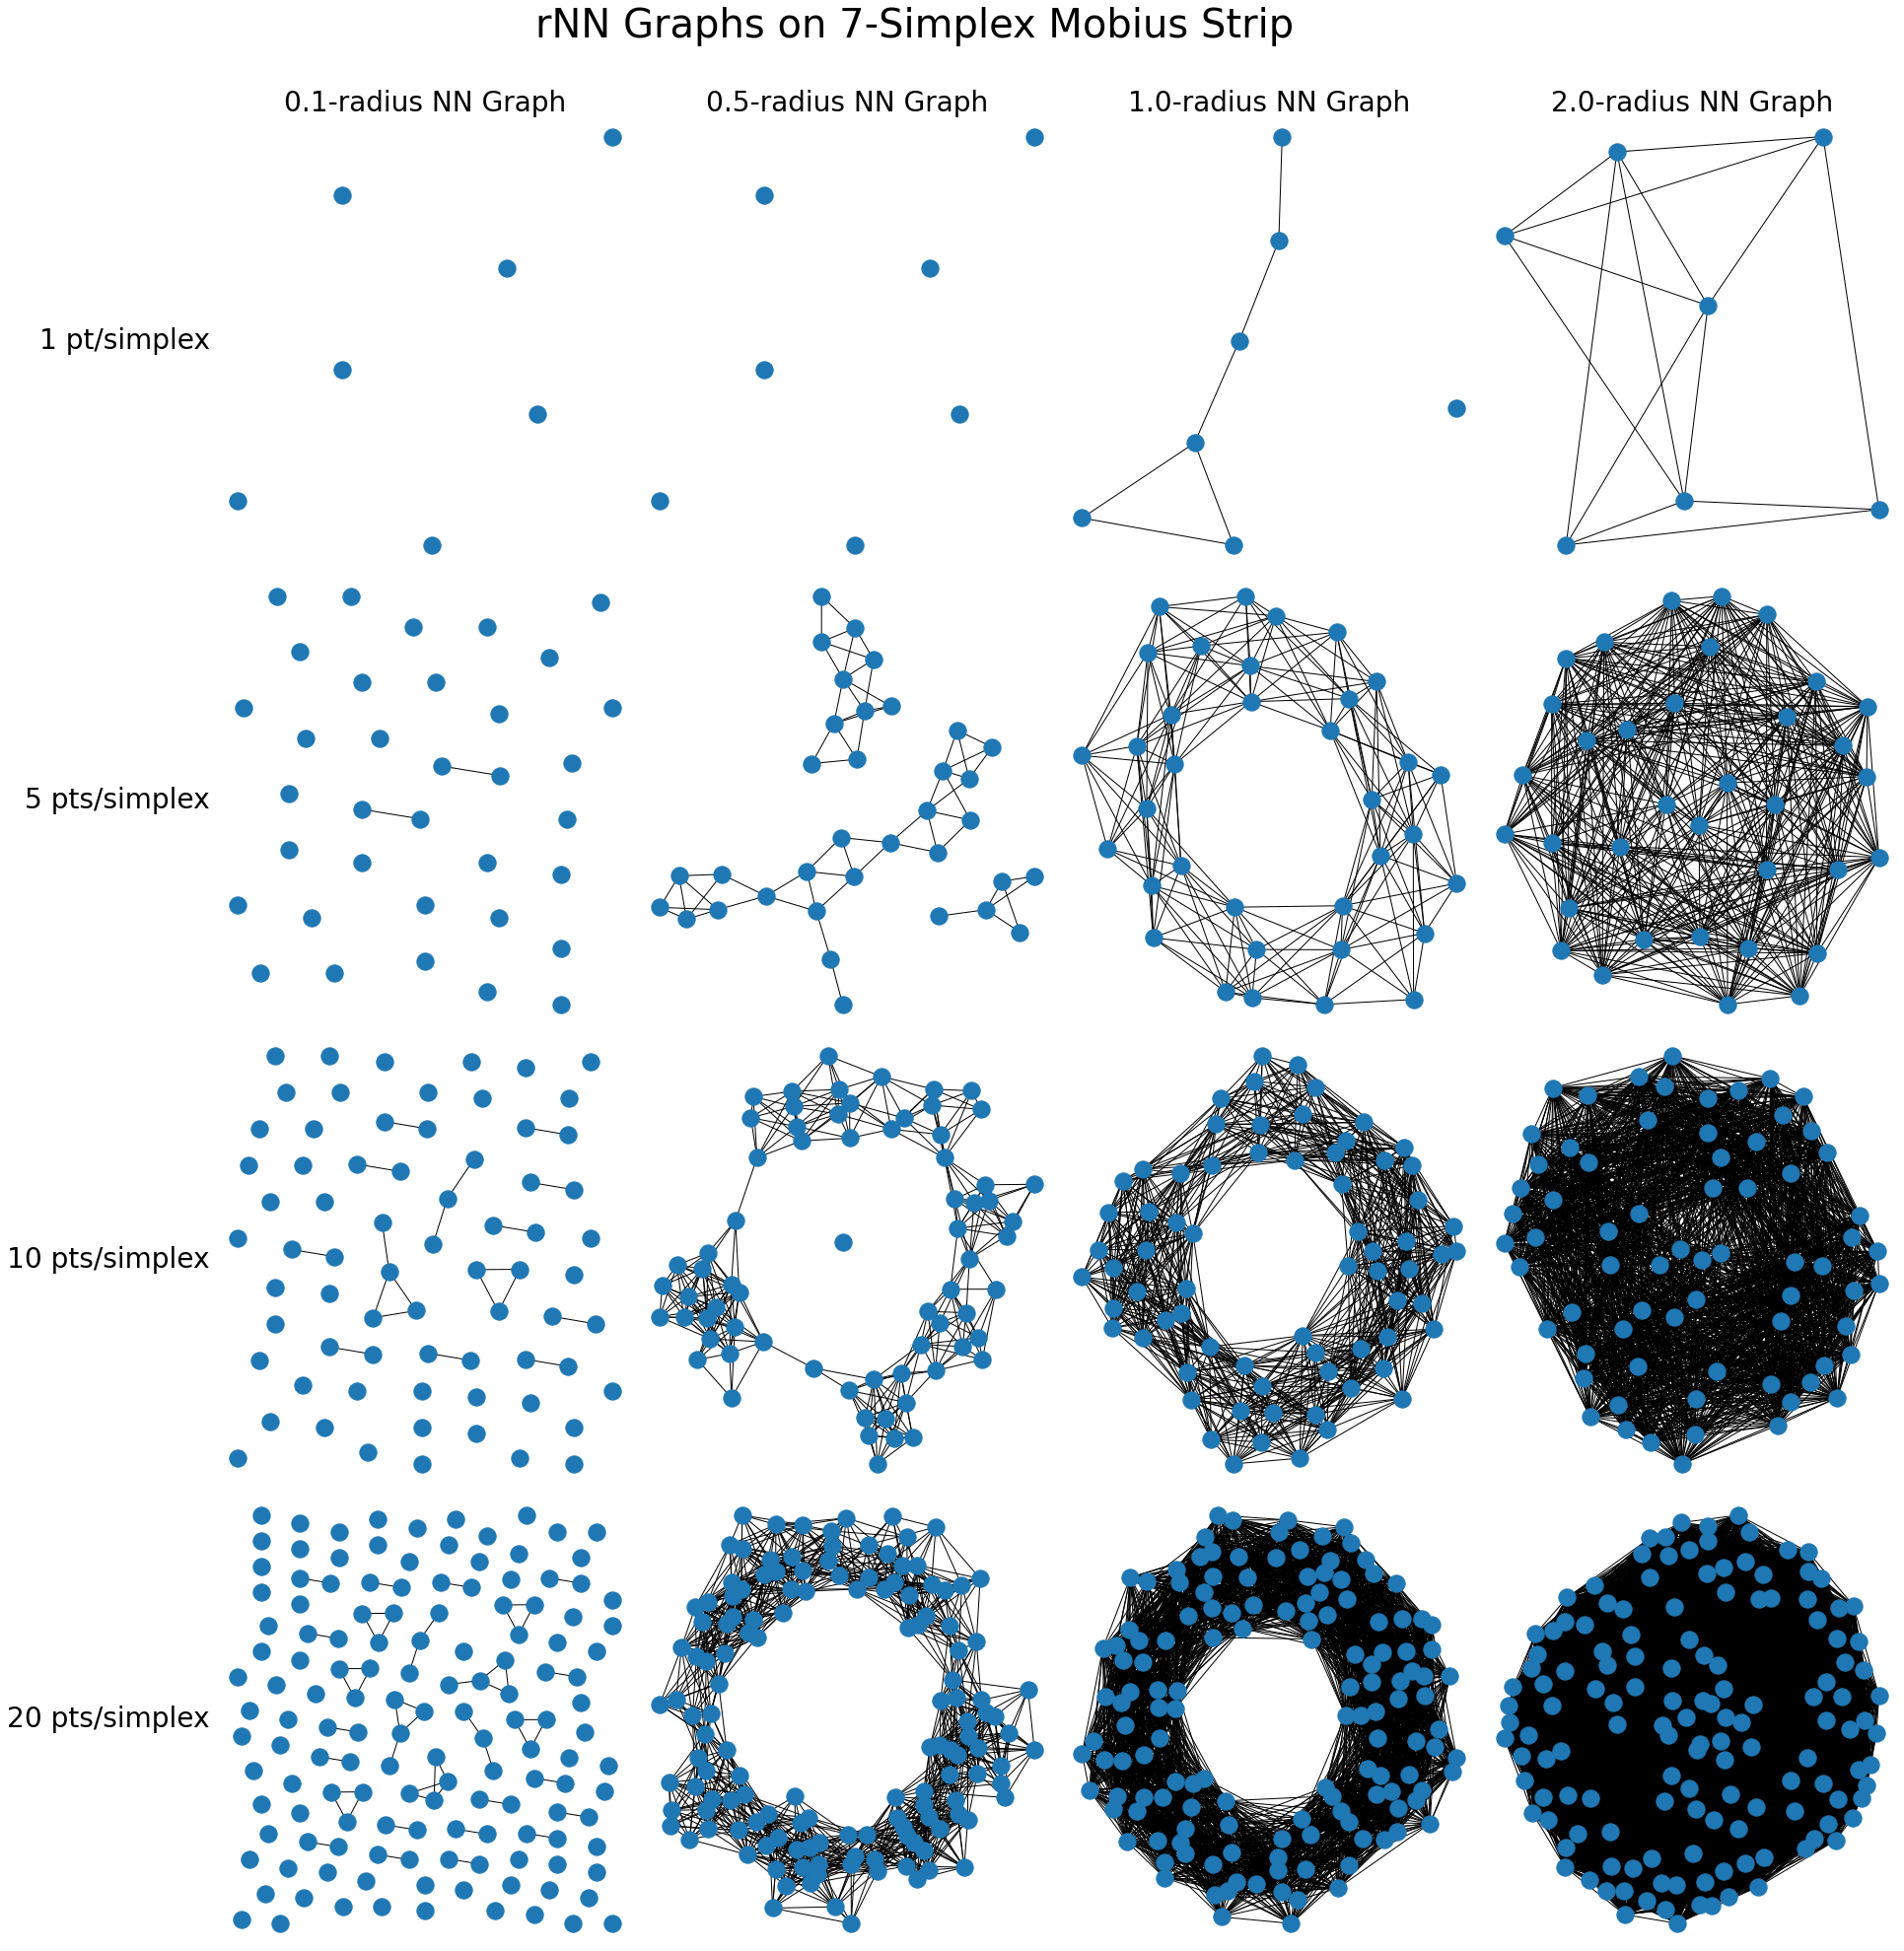

In [35]:
# Plotting
H, W = len(N_options), len(r_options)
mobius_fig, mobius_axes = plt.subplots(nrows=H, ncols=W, figsize=(7*W, 7*H))

pad = 5 # in points

mobius_fig.suptitle(f"rNN Graphs on {len(mobius_M.simplices)}-Simplex Mobius Strip", fontsize=40)

for N, mobius_ax_row in tqdm(list(zip(N_options, mobius_axes)), desc="Varying N", leave=False):   
    for r, mobius_ax in tqdm(list(zip(r_options, mobius_ax_row)), desc="Varying radius", leave=False):
        if N == N_options[0]:
            mobius_ax.annotate(
                f"{r}-radius NN Graph", xy=(0.5, 1), xytext=(0, pad), xycoords='axes fraction',
                textcoords='offset points', size=28, ha='center', va='baseline'
            )
        if r == r_options[0]:
            mobius_ax.annotate(
                f"{N} pt{'s' if N > 1 else ''}/simplex", xy=(0, 0.5),
                xytext=(-mobius_ax.yaxis.labelpad - pad, 0),
                xycoords='axes fraction', textcoords='offset points', size=28, ha='right', va='center'
            )

        G = mobius_all_Gs[(N, r)]
        nx.draw(G, pos=graphviz_layout(G, 'neato'), ax=mobius_ax)
        
mobius_fig.tight_layout()
mobius_fig.subplots_adjust(left=0.15, top=0.925)